In [1]:
from datetime import datetime, timedelta
import sys

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import yfinance as yf

sys.path.append('..')
from util.batcher import Batcher
#from util.stock_loader import Loader

In [2]:
TODAY = datetime.now().date()
TOMORROW  = TODAY + timedelta(1)
TOMORROW

datetime.date(2022, 8, 28)

In [3]:
#sp1950 = yf.download('^GSPC', start='1950-01-01', end=str(TOMORROW))
#nya1965 = yf.download('^NYA', start='1965-01-01', end=str(TOMORROW))
#nasdaq1965 = yf.download('^IXIC', start='1965-01-01', end=str(TOMORROW))
#wilshire1990 = yf.download(
#    '^W5000', start='1990-01-01', end=str(TOMORROW))

path = '../data'
#sp1950.to_csv(f'{path}/sp1950.csv')
#nya1965.to_csv(f'{path}/nya1965.csv')
#nasdaq1965.to_csv(f'{path}/nasdaq1965.csv')
#wilshire1990.to_csv(f'{path}/wilshire1990.csv')
#nasdaq1965.tail()
states = pd.read_csv(f'{path}/hmm_exp_returns.csv')
states.index = pd.to_datetime(states.Date)
states.tail()

,Date,sp,sp_daily,sp_exp,nyse,nyse_daily,nyse_exp,nas,nas_daily,nas_exp,wil,wil_daily,wil_exp,mean_exp,state
Date,,,,,,,,,,,,,,,
2022-08-22,2022-08-22,4137.990234,0.978600,1.000018,15341.849609,0.984189,1.000162,12381.570312,0.974526,1.000523,41273.171875,0.978564,1.000353,1.000264,0
2022-08-23,2022-08-23,4128.729980,0.997762,1.000018,15338.150391,0.999759,1.000162,12381.299805,0.999978,1.000523,41224.390625,0.998818,1.000353,1.000264,0
2022-08-24,2022-08-24,4140.770020,1.002916,1.000018,15392.059570,1.003515,1.000162,12431.530273,1.004057,1.000523,41395.699219,1.004156,1.000353,1.000264,0
2022-08-25,2022-08-25,4199.120117,1.014092,1.000018,15595.240234,1.013200,1.000162,12639.269531,1.016711,1.000523,42005.289062,1.014726,1.000353,1.000264,0
2022-08-26,2022-08-26,4057.659912,0.966312,1.000018,15178.208008,0.973259,1.000162,12141.709961,0.960634,1.000523,40598.789062,0.966516,1.000353,1.000264,0


In [4]:
SYMBOLS = [
    'AAPL', 'ABMD', 'ABNB', 'ADBE', 'ADYEY', 'AMD', 'AMZN', 'ANET',
    'ASML', 'AXON', 'BROS', 'BYND', 'CHWY', 'DDOG', 'DOCS', 'DOCU',
    'DUOL', 'EDIT', 'ETSY', 'FLGT', 'GH', 'GMED', 'GOOG', 'IDXX',
    'INTG', 'ISRG', 'JD', 'LSPD', 'LULU', 'MDB', 'MELI', 'MNST', 'MSFT',
    'MTCH', 'NVCR', 'NVDA', 'OKTA', 'OPEN', 'PAC', 'PANW', 'PAYC',
    'PINS', 'PYPL', 'QDEL', 'RBLX', 'RDFN', 'RGEN', 'RIVN', 'ROKU',
    'RVLV', 'SE', 'SHOP', 'SNOW', 'TASK', 'TDOC', 'TEAM', 'TREX', 'TTD',
    'TTWO', 'TWLO', 'TWTR', 'TYL', 'UPST', 'VEEV', 'VLD', 'XPEV', 'ZEN',
    'ZM']
BEST_0 = ['ALJJ', 'AVEO']
len(SYMBOLS)

68

In [5]:
TODAY = (datetime.now() + timedelta(1)).date()
YEARS_OF_DATA = 5
START = TODAY - timedelta(YEARS_OF_DATA * 365)
START, TODAY

(datetime.date(2017, 8, 29), datetime.date(2022, 8, 28))

In [9]:
batch = sorted(SYMBOLS + BEST_0) #+ INDICES

In [10]:
data = (yf.download(batch, start=START, end=TODAY)
        .rename(columns={'Adj Close': 'AdjClose'}))

[*********************100%***********************]  70 of 70 completed


In [11]:
data['state'] = states.state
data.tail()

AdjClose                                                       \
                  AAPL        ABMD        ABNB        ADBE      ADYEY  ALJJ   
Date                                                                          
2022-08-22  167.570007  261.350006  111.389999  411.350006  15.900000  1.49   
2022-08-23  167.229996  262.230011  111.599998  410.410004  15.750000  1.48   
2022-08-24  167.529999  268.040009  114.510002  405.649994  16.545000  1.50   
2022-08-25  170.029999  274.450012  117.029999  403.929993  16.809999  1.55   
2022-08-26  163.619995  258.119995  112.820000  381.019989  15.760000  1.50   

                                                           ...   Volume  \
                  AMD        AMZN        ANET        ASML  ...     TWLO   
Date                                                       ...            
2022-08-22  92.839996  133.220001  127.139999  520.070007  ...  3975400   
2022-08-23  92.489998  133.619995  126.959999  525.750000  ...  3358700   
2022-08-24  92.730003  133.800003  125.629997  525.440002  ...  2939100   
2022-08-25  97.180000  137.279999  126.489998  539.739990  ...  2795500   
2022-08-26  91.180000  130.750000  123.029999  509.940002  ...  3997500   

                                                                         \
                TWTR     TYL       UPST     VEEV        VLD        XPEV   
Date                                                                      
2022-08-22   7904500  140500  7525200.0   597100  1820900.0   8727700.0   
2022-08-23  26037300  158300  5573500.0   664300  1497100.0  28802200.0   
2022-08-24  17136700  123900  5007300.0   813200  1136900.0  11497500.0   
2022-08-25  10349500  149000  6940800.0  1068000   913700.0  19912500.0   
2022-08-26  10141900  158600  8943700.0  1183000  1338500.0  16026400.0   

                                state  
                ZEN          ZM        
Date                                   
2022-08-22  1696800   8274100.0     0  
2022-08-23  1180900  31475400.0     0  
2022-08-24  1077900  11133300.0     0  
2022-08-25  1072300   5409700.0     0  
2022-08-26  1620800   5922600.0     0  

[5 rows x 421 columns]

In [12]:
STATES = sorted(states.state.unique())
STATES

[0, 1, 2, 3]

In [13]:
CURRENT_STATE = states.state[-1]
CURRENT_STATE

0

In [14]:
def get_stock_data(stock, data):
    sub = data.loc[
        :,  
        [x for x in list(data) if x[1] == stock]]
    first_value = sub.AdjClose[stock][sub.AdjClose[stock].notna()].index[0]
    sub = sub.loc[first_value:, :]
    sub.columns = sub.columns.to_series().apply(lambda x: x[0])
    sub.fillna(method='ffill', inplace=True)
    return sub

In [15]:
def get_daily_returns(x):
    idx = x.index
    n = len(x)
    x = np.array(x)
    #return x[2:n] / x[1:(n - 1)] - 1 
    returns = x[1:n] / x[0:(n-1)] - 1
    returns = pd.Series(returns, index=idx[1:])
    return returns

In [16]:
def get_sharpe(returns, window=None):
    n = len(returns)
    if window is None:
        window = n
    if len(returns) > window:
        returns = returns[(n - window):n]
    returns = returns[~np.isnan(returns)]
    sharpe = (np.sqrt(252) * returns.mean()) / returns.std()
    return sharpe

In [17]:
def rescale(a):
    a = a - a.min()
    a = a / a.max()
    return a

In [18]:
def vals_to_quantiles(a):
    n = len(a)
    qs = np.linspace(0, 1, n)
    order = np.argsort(a)
    out = qs[order]
    return out

In [19]:
def get_rsi(stock_data, window=14):
    df = stock_data.copy()
    df['deltas'] = df.AdjClose.diff(1)
    df['gains'] = df.deltas.clip(lower=0)
    df['losses'] = df.deltas.clip(upper=0).abs()
    df['avg_gain'] = (df.gains
                      .rolling(window=window, min_periods=window)
                      .mean()[:window + 1])
    df['avg_loss'] = (df.losses
                      .rolling(window=window, min_periods=window)
                      .mean()[:window + 1])
    
    # avg gains
    pd.options.mode.chained_assignment = None
    for i, row in enumerate(df.avg_gain.iloc[window + 1:]):
        df.avg_gain.iloc[i + window + 1] = (
            (df.avg_gain.iloc[i + window] * (window - 1) 
             + df.gains.iloc[i + window + 1]) 
            / window)
    # avg losses
    for i, row in enumerate(df.avg_loss.iloc[window + 1:]):
        df.avg_loss.iloc[i + window + 1] = (
            (df.avg_loss.iloc[i + window] * (window - 1)
             + df.losses.iloc[i + window + 1])
            / window)
    df['rs'] = df.avg_gain / df.avg_loss
    df['rsi'] = 100 - (100 / (1. + df.rs))
    return df.rsi

In [20]:
def get_macd(stock_data, fast=60, slow=90, signal=80, plot=False):
    df = stock_data.copy()
    exp1 = df.AdjClose.ewm(span=fast, adjust=False).mean()
    exp2 = df.AdjClose.ewm(span=slow, adjust=False).mean()
    macd = exp1 - exp2
    exp3 = macd.ewm(span=signal, adjust=False).mean()
    histo = macd - exp3
    hdiff = histo.diff(1)
    is_rising = 1 * (hdiff > 0)
    if plot:
        plt.plot(macd, label='MACD', color='red')
        plt.plot(exp3, label='Signal', color='green')
        #plt.xlim(pd.to_datetime('2021-01-01'), 
        #         pd.to_datetime('2021-10-14'))
        plt.legend();
        plt.figure()
        plt.plot(histo, color='blue')
        #plt.xlim(pd.to_datetime('2021-01-01'), 
        #         pd.to_datetime('2021-10-14'))
        plt.axhline(y=0, color='k')
        plt.figure()
        plt.plot(is_rising)
        #plt.xlim(pd.to_datetime('2021-01-01'), 
        #         pd.to_datetime('2021-10-14'))
    return is_rising

In [21]:
LMB = 0.9
RSI_WINDOW = 14
MACD_PARAMS = (60, 90, 80, False)

In [22]:
stock_data = get_stock_data('AAPL', data.copy())
daily_returns = get_daily_returns(stock_data.AdjClose)
daily_returns
get_sharpe(daily_returns[data.state == CURRENT_STATE])

-0.9927911865890718

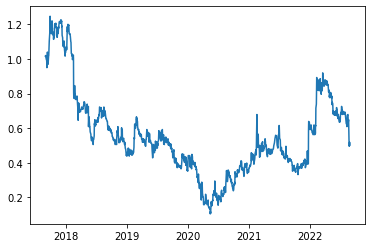

In [35]:
plt.plot((get_daily_returns(data[('AdjClose', 'ALJJ')]) + 1).cumprod());

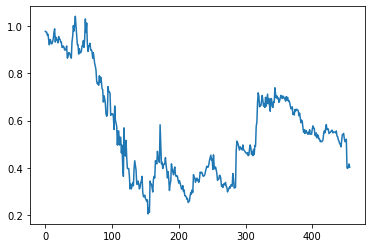

In [36]:
plt.plot((get_daily_returns(data[('AdjClose', 'ALJJ')])[states.state == CURRENT_STATE] + 1).to_numpy().cumprod());

In [28]:
def process_stock(stock, data, lmb=LMB, plot=False):
    stock_data = get_stock_data(stock, data)
    n = len(stock_data.AdjClose[~np.isnan(stock_data.AdjClose)])
    stock_data['direction'] = get_macd(stock_data, *MACD_PARAMS)
    stock_data['rsi'] = get_rsi(stock_data, window=RSI_WINDOW)
    stock_data.rsi = stock_data.rsi.rank(pct=True)
    daily_returns = get_daily_returns(stock_data.AdjClose)
    sharpe = get_sharpe(daily_returns)
    state_sharpe = get_sharpe(daily_returns[data.state == CURRENT_STATE])
    stock_data.fillna(method='ffill', inplace=True)
    stock_data.fillna(method='bfill', inplace=True)
    WINDOW = min(n // 2, 125)
    stock_data['ann_high'] = (
        stock_data.AdjClose.rolling(window=WINDOW).max())
    stock_data['ann_low'] = (
        stock_data.AdjClose.rolling(window=WINDOW).min())
    stock_data['drawdown'] = stock_data.AdjClose / stock_data.ann_high
    stock_data.drawdown = stock_data.drawdown.rank(pct=True)
    stock_data['pullup'] = stock_data.AdjClose / stock_data.ann_low
    stock_data.pullup = stock_data.pullup.rank(pct=True)
    w = [lmb ** t for t in range(n)][::-1]
    stock_data['W'] = w
    stock_data['n_samp'] = (stock_data.Volume / 100)  * stock_data.W
    stock_data['value'] = (
        (stock_data.Close + stock_data.High + stock_data.Low + stock_data.Open) 
        / 4)
    stock_data['est'] = np.nan
    for day in stock_data.index:
        sub = stock_data[stock_data.index <= day]
        weights = sub.n_samp
        weights = weights / weights.sum()
        values = sub.value
        est = np.dot(weights, values)
        stock_data.loc[day, 'est'] = est
    stock_data['resid'] = stock_data.AdjClose / stock_data.est
    stock_data.resid = stock_data.resid.rank(pct=True)
    stock_data.sort_values('resid', inplace=True)
    stock_data['dev'] = np.array(range(n)) / n
    stock_data.dev = stock_data.dev.rank(pct=True)
    stock_data.sort_index(inplace=True)
    if plot:
        plt.figure(figsize=(12, 8))
        plt.plot(stock_data.Close, label='Close')
        plt.plot(stock_data.est, label='Est')
        plt.yscale('log')
        plt.plot(stock_data.ann_high, color='green')
        plt.plot(stock_data.ann_low, color='red')
        plt.legend();
        plt.figure(figsize=(12, 4))
        plt.plot(stock_data.dev)
        plt.axhline(0.5, color='k')
        plt.title(stock)
        plt.figure(figsize=(12, 4))
        plt.plot(stock_data.drawdown, color='red', label='drawdown')
        plt.plot(stock_data.pullup, color='green', label='pullup')
        plt.plot(
            np.sqrt(stock_data.drawdown * stock_data.pullup),
            color='grey',
            label='geomean')
        plt.yscale('log')
        plt.legend()
    return (
        stock_data.direction.tolist()[-1],
        stock_data.rsi.tolist()[-1],
        stock_data.resid.tolist()[-1], 
        stock_data.dev.tolist()[-1],
        stock_data.drawdown.tolist()[-1],
        stock_data.pullup.tolist()[-1],
        sharpe,
        state_sharpe)

(0,
 0.028135048231511254,
 0.18600953895071543,
 0.18600953895071543,
 0.12742504409171077,
 0.08862433862433862,
 0.26120219585077425,
 0.09983856431148064)

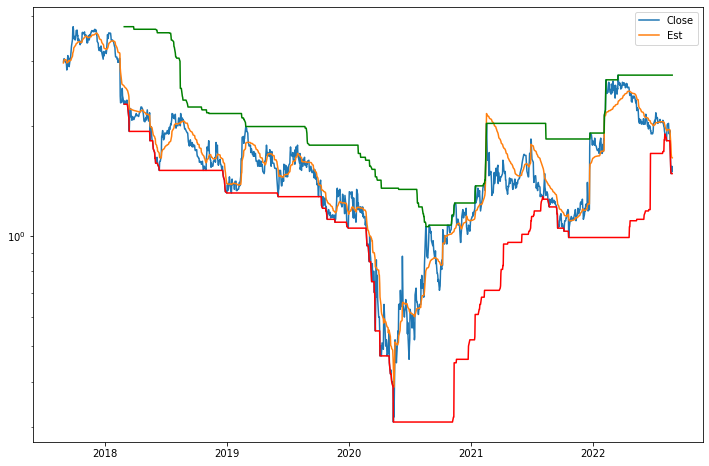

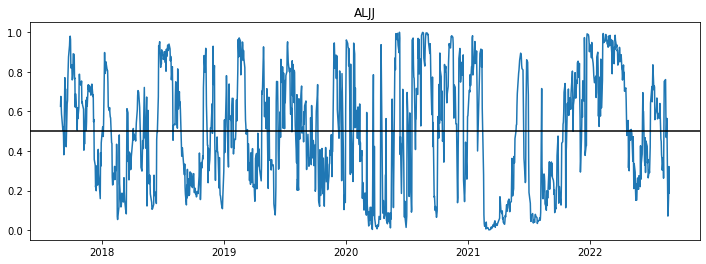

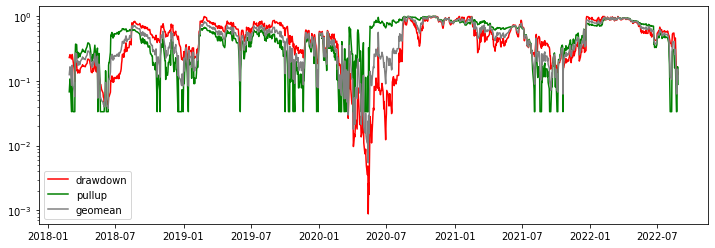

In [29]:
process_stock('ALJJ', data.copy(), plot=True)

In [30]:
out = []
for stock in batch:
    print(f'{stock}...', end=' ')
    direction, rsi, mult, dev, drop, climb, sharpe, state_sharpe = process_stock(
        stock, data)
    out.append([stock, direction, rsi, mult, dev, drop, climb, sharpe, state_sharpe])

AAPL... ABMD... ABNB... ADBE... ADYEY... ALJJ... AMD... AMZN... ANET... ASML... AVEO... AXON... BROS... BYND... CHWY... DDOG... DOCS... DOCU... DUOL... EDIT... ETSY... FLGT... GH... GMED... GOOG... IDXX... INTG... ISRG... JD... LSPD... LULU... MDB... MELI... MNST... MSFT... MTCH... NVCR... NVDA... OKTA... OPEN... PAC... PANW... PAYC... PINS... PYPL... QDEL... RBLX... RDFN... RGEN... RIVN... ROKU... RVLV... SE... SHOP... SNOW... TASK... TDOC... TEAM... TREX... TTD... TTWO... TWLO... TWTR... TYL... UPST... VEEV... VLD... XPEV... ZEN... ZM... 

In [31]:
out = pd.DataFrame(
    data=out, 
    columns=['stock', 'direction', 'RSI', 'fair_value_mult', 
             'dev_quantile', 'drop','climb', 'sharpe', 'state_sharpe'])
out['geomean'] = np.sqrt(out['drop'] * out.climb)
out['score'] = (out.fair_value_mult
                * out.dev_quantile
                * out['drop']
                * out.climb) ** (1/4) 
out['RSIRev'] = 1 - out.RSI
out = out[['stock', 'direction', 'RSI', 'RSIRev', 'fair_value_mult', 
           'dev_quantile', 'drop', 'climb','geomean', 'score', 
           'sharpe', 'state_sharpe']]
out.RSI.fillna(out.RSI.median())
out.RSIRev.fillna(out.RSIRev.median())

out.sort_values('stock')

,stock,direction,RSI,RSIRev,fair_value_mult,dev_quantile,drop,climb,geomean,score,sharpe,state_sharpe
0,AAPL,0,0.307074,0.692926,0.401431,0.401431,0.391534,0.488536,0.437354,0.419008,1.059903,-0.992791
1,ABMD,0,0.155145,0.844855,0.110493,0.110493,0.335979,0.384480,0.359412,0.199280,0.486561,-0.831392
2,ABNB,1,0.462830,0.537170,0.392111,0.392111,0.211726,0.680782,0.379657,0.385834,0.038709,-0.715428
3,ADBE,0,0.031350,0.968650,0.019873,0.019873,0.148148,0.134921,0.141380,0.053006,0.689933,-1.333548
4,ADYEY,0,0.160391,0.839609,0.069767,0.069767,0.227348,0.383031,0.295095,0.143485,0.888503,-0.194566
...,...,...,...,...,...,...,...,...,...,...,...,...
65,VEEV,0,0.143087,0.856913,0.077901,0.077901,0.412698,0.555556,0.478829,0.193136,0.837959,-1.031863
66,VLD,1,0.636598,0.363402,0.286070,0.286070,0.287770,0.960432,0.525722,0.387805,-0.346334,-0.788548
67,XPEV,0,0.034694,0.965306,0.113095,0.113095,0.363158,0.044737,0.127462,0.120064,0.380564,-0.504881
68,ZEN,1,0.513666,0.486334,0.408585,0.408585,0.044092,0.552910,0.156137,0.252577,0.681396,-0.739115


In [32]:
out.geomean.quantile([0.05, 0.99])

0.05    0.068427
0.99    0.887759
Name: geomean, dtype: float64

In [33]:
out.to_csv('individ_quantiles.csv', index=False)

In [34]:
!open individ_quantiles.csv